#### This notebook is used to train a character recongition from input image using MobileNets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/dataset_characters" "/content/"
!cp -r "/content/drive/My Drive/Plate_examples" "/content/"
!cp -r "/content/drive/My Drive/Plate_examples_2" "/content/"
!cp -r "/content/drive/My Drive/Files" "/content/"
!cp -r "/content/drive/My Drive/Files/local_utils.py" "/content/"

In [ ]:
# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers.legacy import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

### Visualize dataset

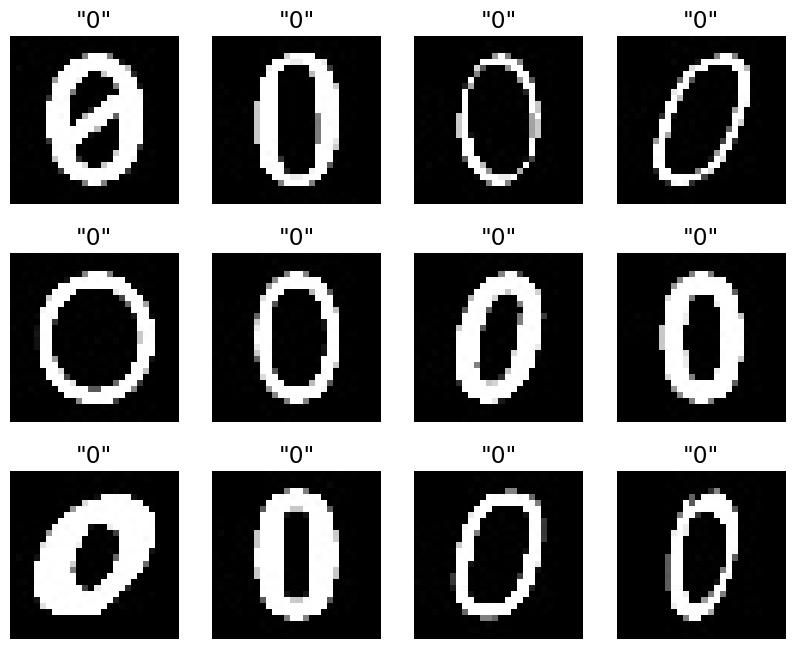

In [ ]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)


## Data pre-processing

In [ ]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 689 images with 1 classes


In [ ]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [ ]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

## Initialize MobileNets architecture with pre-trained weight

In [ ]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr,decay, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet",
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(learning_rate=lr, decay = decay)
        model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])

    return model

In [ ]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

9406464/9406464 [==============================] - 1s 0us/step


## Train model

In [ ]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE),
                   steps_per_epoch=len(trainX) // BATCH_SIZE,
                   validation_data=(testX, testY),
                   validation_steps=len(testX) // BATCH_SIZE,
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 1.0000
Epoch 1: saving model to License_character_recognition.h5
9/9 [==============================] - 18s 356ms/step - loss: 0.2075 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 1.0000
Epoch 2: saving model to License_character_recognition.h5
9/9 [==============================] - 1s 160ms/step - loss: 0.0357 - accuracy: 1.0000 - val_loss: 2.6453e-04 - val_accuracy: 1.0000
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000
Epoch 3: saving model to License_character_recognition.h5
9/9 [==============================] - 2s 256ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 9.2121e-05 - val_accuracy: 1.0000
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 4: saving model to License_character_recognition.h5
9/9 

## Visualize training result

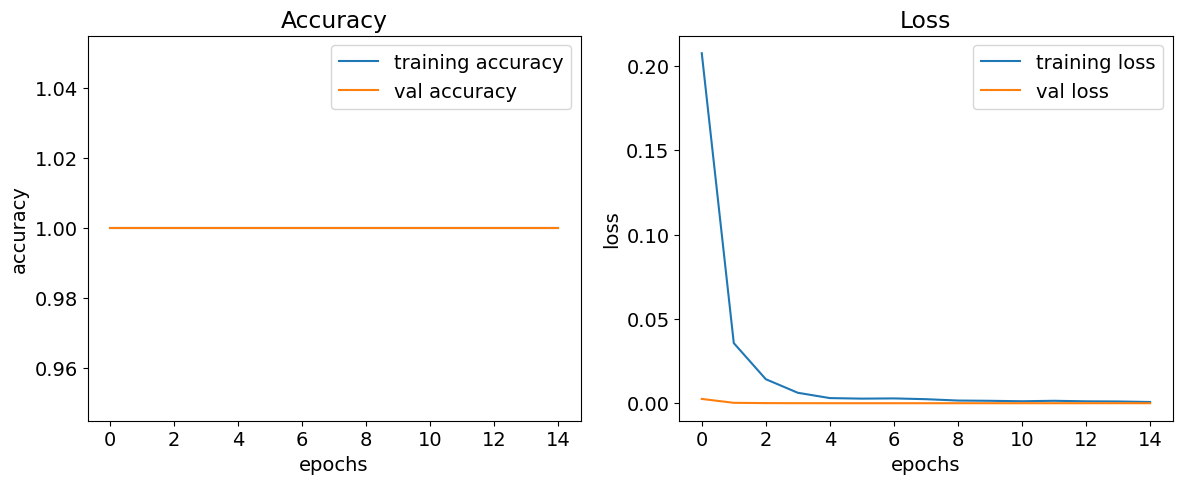

In [ ]:

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#plt.savefig("Training_result.jpg",dpi=300)

In [ ]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

## The End!